In [560]:
import pandas as pd
import sklearn.decomposition
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import math
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
import random
from operator import itemgetter

In [6]:
denovo_X = pd.read_csv('/gymreklab-tscc/cynthiawu/BXD_str/denovo_ri_gts_hom_chrX_rnt.tsv', index_col=0)

In [7]:
denovo_X

,chr,pos,end,strain,RN_A,RN_B,founder,fou_het,fou_gt,founder_rn,delta_fou,expand_sign,expand_type,RN_T
1,chrX,5893968,5894015,BXD156,13,13,B,False,12/12,12,1,1,expan,26
2,chrX,5943473,5943520,BXD168,13,13,D,False,12/12,12,1,1,expan,26
3,chrX,5977464,5977523,BXD148,13,13,B,False,12/12,12,1,1,expan,26
4,chrX,6770030,6770065,BXD021,7,7,B,False,9/9,9,2,-1,contr,14
5,chrX,6866581,6866596,BXD174,7,7,B,False,8/8,8,1,-1,contr,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1038,chrX,169812269,169812296,BXD152,8,8,B,False,7/7,7,1,1,expan,16
1039,chrX,169812269,169812296,BXD155,8,8,B,False,7/7,7,1,1,expan,16
1040,chrX,169942093,169942112,BXD029,2,2,B,False,4/4,4,2,-1,contr,4
1041,chrX,170677547,170677573,BXD005,4,4,B,False,3/3,3,1,1,expan,8


# PCA on X data to find outlier sample to filter out

In [712]:
cols = ['chr', 'pos', 'end']
denovo_X['chr_pos'] = denovo_X[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
denovo_X['has_newvar'] = 1
strain_by_loc = denovo_X.pivot_table(index='chr_pos', columns='strain', values='has_newvar', fill_value=0).T

#perform pca
pca_t = sklearn.decomposition.PCA()
pca_t.fit(strain_by_loc)
values_strain_by_loc = pca_t.transform(strain_by_loc)

In [714]:
# read strain info
strain_info = pd.read_csv('/storage/cynthiawu/BXD_str/BXD-STR-Mutator-Manuscript/outs/strain_info.csv')
strain_info['off_epoch'] = strain_info['off_epoch'].str.replace('epoch_1b','epoch_1a')
strain_info['off_epoch'] = strain_info['off_epoch'].str.replace('epoch_1c','epoch_1a')

strain_epoch = strain_info[['bxd_id', 'off_epoch']]
strain_epoch = strain_epoch[strain_epoch['bxd_id'].isin(strain_by_loc.index)]

#set colors for epochs 
colors = {'epoch_1a':'red', 'epoch_2':'green', 'epoch_3a':'blue', 'epoch_3b':'yellow', 'epoch_4':'purple', 'epoch_5':'brown', 'epoch_6':'orange', 'epoch_7':'gray'}


Text(0, 0.5, 'PC2')

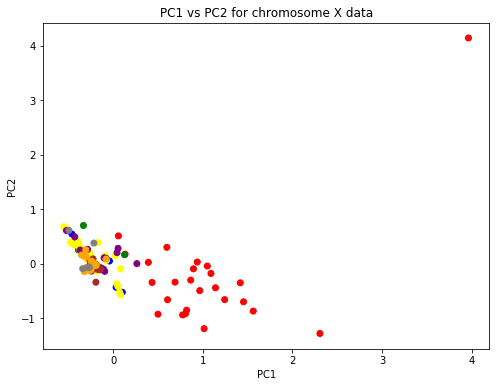

In [719]:
#Plot PC 1 vs PC2, observe outlier
fig = plt.figure()
fig.set_size_inches((8, 6))
ax = fig.add_subplot(111)
ax.scatter(values_strain_by_loc[:,0], values_strain_by_loc[:,1], c=strain_epoch['off_epoch'].map(colors))
plt.title('PC1 vs PC2 for chromosome X data')
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")

In [723]:
# outlier is at index 23
max_value = max(values_strain_by_loc[:,0])
max_index = list(values_strain_by_loc[:,0]).index(max_value)
strain_by_loc.index[max_index]

# filter out outlier 'BXD031'
strain_by_loc_filter = strain_by_loc.drop([strain_by_loc.index[max_index]])

strain_epoch = strain_info[['bxd_id', 'off_epoch']]
strain_epoch = strain_epoch[strain_epoch['bxd_id'].isin(strain_by_loc_filter.index)]

In [724]:
pca_t = sklearn.decomposition.PCA()
pca_t.fit(strain_by_loc_filter)
values_strain_by_loc_filter = pca_t.transform(strain_by_loc_filter)

Text(0, 0.5, 'PC2')

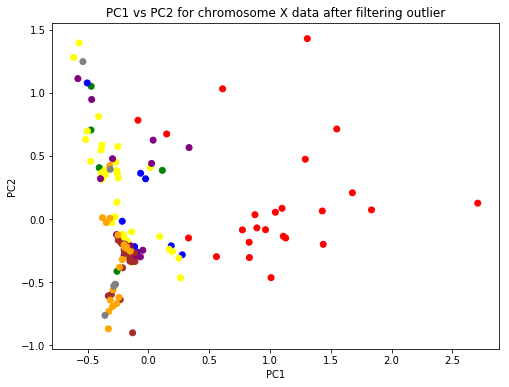

In [725]:
fig = plt.figure()
fig.set_size_inches((8, 6))
ax = fig.add_subplot(111)
ax.scatter(values_strain_by_loc_filter[:,0], values_strain_by_loc_filter[:,1], c=strain_epoch['off_epoch'].map(colors))
plt.title('PC1 vs PC2 for chromosome X data after filtering outlier')
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")

# B vs D for X, Y, autosomes

In [728]:
all_phenos_X = pd.read_csv('/gymreklab-tscc/cynthiawu/BXD_str/all_phenos_chrX.tsv', sep='\t')
all_phenos_Y = pd.read_csv('/gymreklab-tscc/cynthiawu/BXD_str/all_phenos_chrY.tsv', sep='\t')
all_phenos_autosomes = pd.read_csv('/gymreklab-tscc/cynthiawu/BXD_str/all_phenos_autosomes.tsv', sep='\t')

#only have % expanded data
all_phenos_X_filter = all_phenos_X[all_phenos_X['metric']=='% expanded']
all_phenos_Y_filter = all_phenos_Y[all_phenos_Y['metric']=='% expanded']
all_phenos_autosomes_filter = all_phenos_autosomes[all_phenos_autosomes['metric']=='% expanded']
all_phenos_X_filter = all_phenos_X_filter[all_phenos_X_filter['strain']!='BXD031']

all_phenos_X_filter = all_phenos_X_filter.rename(columns={'pheno': 'pheno_X'})
all_phenos_Y_filter = all_phenos_Y_filter.rename(columns={'pheno': 'pheno_Y'})
all_phenos_autosomes_filter = all_phenos_autosomes_filter.rename(columns={'pheno': 'pheno_autosomes'})

# get total n_mut mutations by pheno*n
all_phenos_X_filter['n_mut'] = all_phenos_X_filter.apply (lambda row: round(row['pheno_X']*row['n']), axis=1)
all_phenos_Y_filter['n_mut'] = all_phenos_Y_filter.apply (lambda row: round(row['pheno_Y']*row['n']), axis=1)
all_phenos_autosomes_filter['n_mut'] = all_phenos_autosomes_filter.apply (lambda row: round(row['pheno_autosomes']*row['n']), axis=1)


In [729]:
all_phenos_X_filter

,min_pts_per_phe,max_denovo_strains_per_loc,strain,motif_len,pheno_X,n,metric,n_mut
6858,0,1000,BXD001,all,0.700000,10,% expanded,7
6859,0,1000,BXD002,all,0.545455,22,% expanded,12
6860,0,1000,BXD005,all,0.600000,15,% expanded,9
6861,0,1000,BXD006,all,0.772727,22,% expanded,17
6862,0,1000,BXD008,all,0.500000,8,% expanded,4
...,...,...,...,...,...,...,...,...
9886,0,1,BXD055,6,1.000000,1,% expanded,1
9887,0,1,BXD061,6,0.000000,1,% expanded,0
9888,0,1,BXD086,6,0.000000,1,% expanded,0
9889,0,1,BXD100,6,1.000000,1,% expanded,1


In [730]:
# get genotypes at chr13 locus
fou_gt_at_peak_chr13 = pd.read_csv('/gymreklab-tscc/cynthiawu/BXD_str/fou_gt_at_peak_chr13.tsv', sep='\t')
all_phenos_X_filter = pd.merge(all_phenos_X_filter, fou_gt_at_peak_chr13, on='strain')
all_phenos_Y_filter = pd.merge(all_phenos_Y_filter, fou_gt_at_peak_chr13, on='strain')
all_phenos_autosomes_filter = pd.merge(all_phenos_autosomes_filter, fou_gt_at_peak_chr13, on='strain')

# combine strain info
all_phenos_X_filter = pd.merge(all_phenos_X_filter, strain_info[['bxd_id', 'off_epoch']], left_on='strain', right_on='bxd_id')
all_phenos_Y_filter = pd.merge(all_phenos_Y_filter, strain_info[['bxd_id', 'off_epoch']], left_on='strain', right_on='bxd_id')
all_phenos_autosomes_filter = pd.merge(all_phenos_autosomes_filter, strain_info[['bxd_id', 'off_epoch']], left_on='strain', right_on='bxd_id')

In [767]:
def get_aggregate_pheno(df, fou_gt, max_denovo_strains_per_loc, motif_len, epoch=None):
    df_nofilter = df[(df['min_pts_per_phe'] == 0) & (df['fou_gt'] == fou_gt) & (df['max_denovo_strains_per_loc'] == max_denovo_strains_per_loc) &(df['motif_len'] == motif_len)]
    if epoch:
        df_nofilter = df_nofilter[df_nofilter['off_epoch'] == epoch]
    n_total = df_nofilter['n'].sum()
    perc_aggregate = (df_nofilter['n_mut'].sum())/n_total
    se = math.sqrt(perc_aggregate*(1-perc_aggregate)/n_total)
    return perc_aggregate, se, n_total

def get_2sample_ztestproportion(df, max_denovo_strains_per_loc, motif_len, epoch=None):
    dfB_nofilter = df[(df['min_pts_per_phe'] == 0) & (df['fou_gt'] == 'B') & (df['max_denovo_strains_per_loc'] == max_denovo_strains_per_loc) &(df['motif_len'] == motif_len)]
    dfD_nofilter = df[(df['min_pts_per_phe'] == 0) & (df['fou_gt'] == 'D') & (df['max_denovo_strains_per_loc'] == max_denovo_strains_per_loc) &(df['motif_len'] == motif_len)]
    n_total1 = dfB_nofilter['n'].sum()
    n_total2 = dfD_nofilter['n'].sum()
    n_mut1 = dfB_nofilter['n_mut'].sum()
    n_mut2 = dfD_nofilter['n_mut'].sum()
    stat, pval = proportions_ztest([n_mut1, n_mut2], [n_total1, n_total2])
    return stat, pval

#get random labels, 0 for first df's new label, 1 for second df's new label
#use indices of random labels to obtain the new number of mutation and mutation total from df
def get_random_n_mut(df):
    n_strains = len(df)
    random_labels = list(np.random.randint(low = 2,size=n_strains))
    random_indices = [i for i in range(len(random_labels)) if random_labels[i] == 0]
    if len(random_indices) > 1: 
        n_mut1 = sum(list(itemgetter(*random_indices)(list(df['n_mut']))))
        n_total1 = sum(list(itemgetter(*random_indices)(list(df['n']))))
    elif(len(random_indices) == 1):
        n_mut1 = list(df['n_mut'])[random_indices[0]]
        n_total1 = list(df['n'])[random_indices[0]]
    elif(len(random_indices) == 0):
        n_mut1 = 0
        n_total1 = 0

    random_indices = [i for i in range(len(random_labels)) if random_labels[i] == 1]
    if len(random_indices) > 1: 
        n_mut2 = sum(list(itemgetter(*random_indices)(list(df['n_mut']))))
        n_total2 = sum(list(itemgetter(*random_indices)(list(df['n']))))
    elif(len(random_indices) == 1):
        n_mut2 = list(df['n_mut'])[random_indices[0]]
        n_total2 = list(df['n'])[random_indices[0]]
    elif(len(random_indices) == 0):
        n_mut2 = 0
        n_total2 = 0

    return n_mut1, n_mut2, n_total1, n_total2
    

def get_empiricalnull_diff(df1, df2, num_sim, max_denovo_strains_per_loc, motif_len, epoch=None):
    dfB_nofilter1 = df1[(df1['min_pts_per_phe'] == 0) & (df1['fou_gt'] == 'B') & (df1['max_denovo_strains_per_loc'] == max_denovo_strains_per_loc) &(df1['motif_len'] == motif_len)]
    dfD_nofilter1 = df1[(df1['min_pts_per_phe'] == 0) & (df1['fou_gt'] == 'D') & (df1['max_denovo_strains_per_loc'] == max_denovo_strains_per_loc) &(df1['motif_len'] == motif_len)]
    dfB_nofilter2 = df2[(df2['min_pts_per_phe'] == 0) & (df2['fou_gt'] == 'B') & (df2['max_denovo_strains_per_loc'] == max_denovo_strains_per_loc) &(df2['motif_len'] == motif_len)]
    dfD_nofilter2 = df2[(df2['min_pts_per_phe'] == 0) & (df2['fou_gt'] == 'D') & (df2['max_denovo_strains_per_loc'] == max_denovo_strains_per_loc) &(df2['motif_len'] == motif_len)]

    empirical_null = []
    for sim in range(num_sim):
        n1_mut1, n1_mut2, n1_total1, n1_total2 = get_random_n_mut(dfB_nofilter1)
        n2_mut1, n2_mut2, n2_total1, n2_total2 = get_random_n_mut(dfB_nofilter2)
        aggregated_pheno_B1 = (n1_mut1+n2_mut1)/(n1_total1+n2_total1)
        aggregated_pheno_B2 = (n1_mut2+n2_mut2)/(n1_total2+n2_total2)

        n1_mut1, n1_mut2, n1_total1, n1_total2 = get_random_n_mut(dfD_nofilter1)
        n2_mut1, n2_mut2, n2_total1, n2_total2 = get_random_n_mut(dfD_nofilter2)
        aggregated_pheno_D1 = (n1_mut1+n2_mut1)/(n1_total1+n2_total1)
        aggregated_pheno_D2 = (n1_mut2+n2_mut2)/(n1_total2+n2_total2)

        empirical_null.append((aggregated_pheno_B1-aggregated_pheno_D1) - (aggregated_pheno_B2 - aggregated_pheno_D2))
    return empirical_null

#get the empirical pvalue from the simulated empirical null and the observed value
def calculate_empirical(sim_values, obs_value):
    sim_values.sort()
    n_iter = len(sim_values)
    index = n_iter - np.searchsorted(sim_values, obs_value)
    return((index + 1)/(n_iter+1))

# set experiment to have num_trials with each trial having num_sim
def set_experiment(df1, df2, num_sim, num_trials, max_denovo_strains_per_loc, motif_len, epoch=None):
    pvals = []
    for trial in range(num_trials):
        empirical_null = get_empiricalnull_diff(df1, df2, num_sim, max_denovo_strains_per_loc, motif_len, epoch=None)
        aggregated_pheno_B1 = get_aggregate_pheno(df1, 'B', max_denovo_strains_per_loc, motif_len, epoch=None)[0]
        aggregated_pheno_D1 = get_aggregate_pheno(df1, 'D', max_denovo_strains_per_loc, motif_len, epoch=None)[0]
        aggregated_pheno_B2 = get_aggregate_pheno(df2, 'B', max_denovo_strains_per_loc, motif_len, epoch=None)[0]
        aggregated_pheno_D2 = get_aggregate_pheno(df2, 'D', max_denovo_strains_per_loc, motif_len, epoch=None)[0]

        diff_pheno = (aggregated_pheno_B1 - aggregated_pheno_D1) - (aggregated_pheno_B2 - aggregated_pheno_D2)
        pvals.append(calculate_empirical(empirical_null, diff_pheno))
    return pvals
    


## Perfrom 2sample ztest of proportions

In [741]:
max_denovo_strains_per_loc = 10
motif_len = ['4', 'all']
dfs = [all_phenos_X_filter, all_phenos_Y_filter, all_phenos_autosomes_filter]
dfs_lst = ['X', 'Y', 'autosomes']
# parameters to add to dataframe
zscores = []
pvals = []
motif_len_lst = []
chrom_group = []
index = 0

for df in dfs:
    for motif in motif_len:
        zscore, pval = get_2sample_ztestproportion(df, max_denovo_strains_per_loc, motif, epoch=None)
        zscores.append(zscore); pvals.append(pval); motif_len_lst.append(motif); chrom_group.append(dfs_lst[index])
    index += 1

In [751]:
proptest_df = pd.DataFrame(np.array([chrom_group, motif_len_lst, zscores, pvals]).T, columns=['chr', 'motif_len', 'zscores', 'pvals'])
proptest_df


,chr,motif_len,zscores,pvals
0,X,4,0.27766343160953977,0.7812707344667564
1,X,all,1.2101634894584925,0.22621616486733687
2,Y,4,1.3997084244475304,0.16160065002674062
3,Y,all,1.1606026262372307,0.24580353693532409
4,autosomes,4,13.705173138602913,9.45415244615071e-43
5,autosomes,all,13.254378610201368,4.256277019073824e-40


## Test to check for diff Y > diff auto > diff X

- for each strain permute auto/x/y labels for the mutations
- compute *aggregate* values for the % expanded for auto/x/y in B/D 
- get (B_auto-D_auto)-(B_y-D_y)
- repeat to get a null distribution
- compare to the actual observed (B_auto-D_auto)-(B_y-D_y) 

In [689]:
pvals_Y_autosomes = set_experiment(all_phenos_Y_filter, all_phenos_autosomes_filter, 100000, 10, 10, 'all',  epoch=None)
pvals_autosomes_X = set_experiment(all_phenos_autosomes_filter, all_phenos_X_filter, 100000, 10, 10, 'all',  epoch=None)
pvals_Y_X = set_experiment(all_phenos_Y_filter, all_phenos_X_filter, 100000, 10, 10, 'all',  epoch=None)



Text(0, 0.5, 'pvalue')

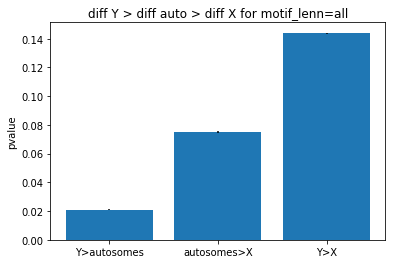

In [770]:
fig, ax = plt.subplots()
labels = ['Y>autosomes', 'autosomes>X', 'Y>X']
x_pos = np.arange(len(labels))
ax.bar(x_pos, [np.mean(pvals_Y_autosomes), np.mean(pvals_autosomes_X), np.mean(pvals_Y_X)], yerr=[np.std(pvals_Y_autosomes), np.std(pvals_autosomes_X), np.std(pvals_Y_X)])
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
plt.title('diff Y > diff auto > diff X for motif_lenn=all')
plt.ylabel('pvalue')


In [768]:
pvals_Y_autosomes_tetra = set_experiment(all_phenos_Y_filter, all_phenos_autosomes_filter, 100000, 10, 10, '4',  epoch=None)
pvals_autosomes_X_tetra = set_experiment(all_phenos_autosomes_filter, all_phenos_X_filter, 100000, 10, 10, '4',  epoch=None)
pvals_Y_X_tetra = set_experiment(all_phenos_Y_filter, all_phenos_X_filter, 100000, 10, 10, '4',  epoch=None)


Text(0, 0.5, 'pvalue')

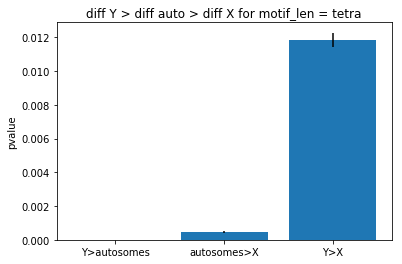

In [771]:
fig, ax = plt.subplots()
labels = ['Y>autosomes', 'autosomes>X', 'Y>X']
x_pos = np.arange(len(labels))
ax.bar(x_pos, [np.mean(pvals_Y_autosomes_tetra), np.mean(pvals_autosomes_X_tetra), np.mean(pvals_Y_X_tetra)], yerr=[np.std(pvals_Y_autosomes_tetra), np.std(pvals_autosomes_X_tetra), np.std(pvals_Y_X_tetra)])
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
plt.title('diff Y > diff auto > diff X for motif_len = tetra')
plt.ylabel('pvalue')


## Barplots for B vs D for X, Y, autosomes

error bar: standard error of binomial
n =# mutation
p = % expanded
SE = sqrt(np(1-p))
max_denovo: 1, 3, 50
separate by epochs

/storage/cynthiawu/miniconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in long_scalars
  
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


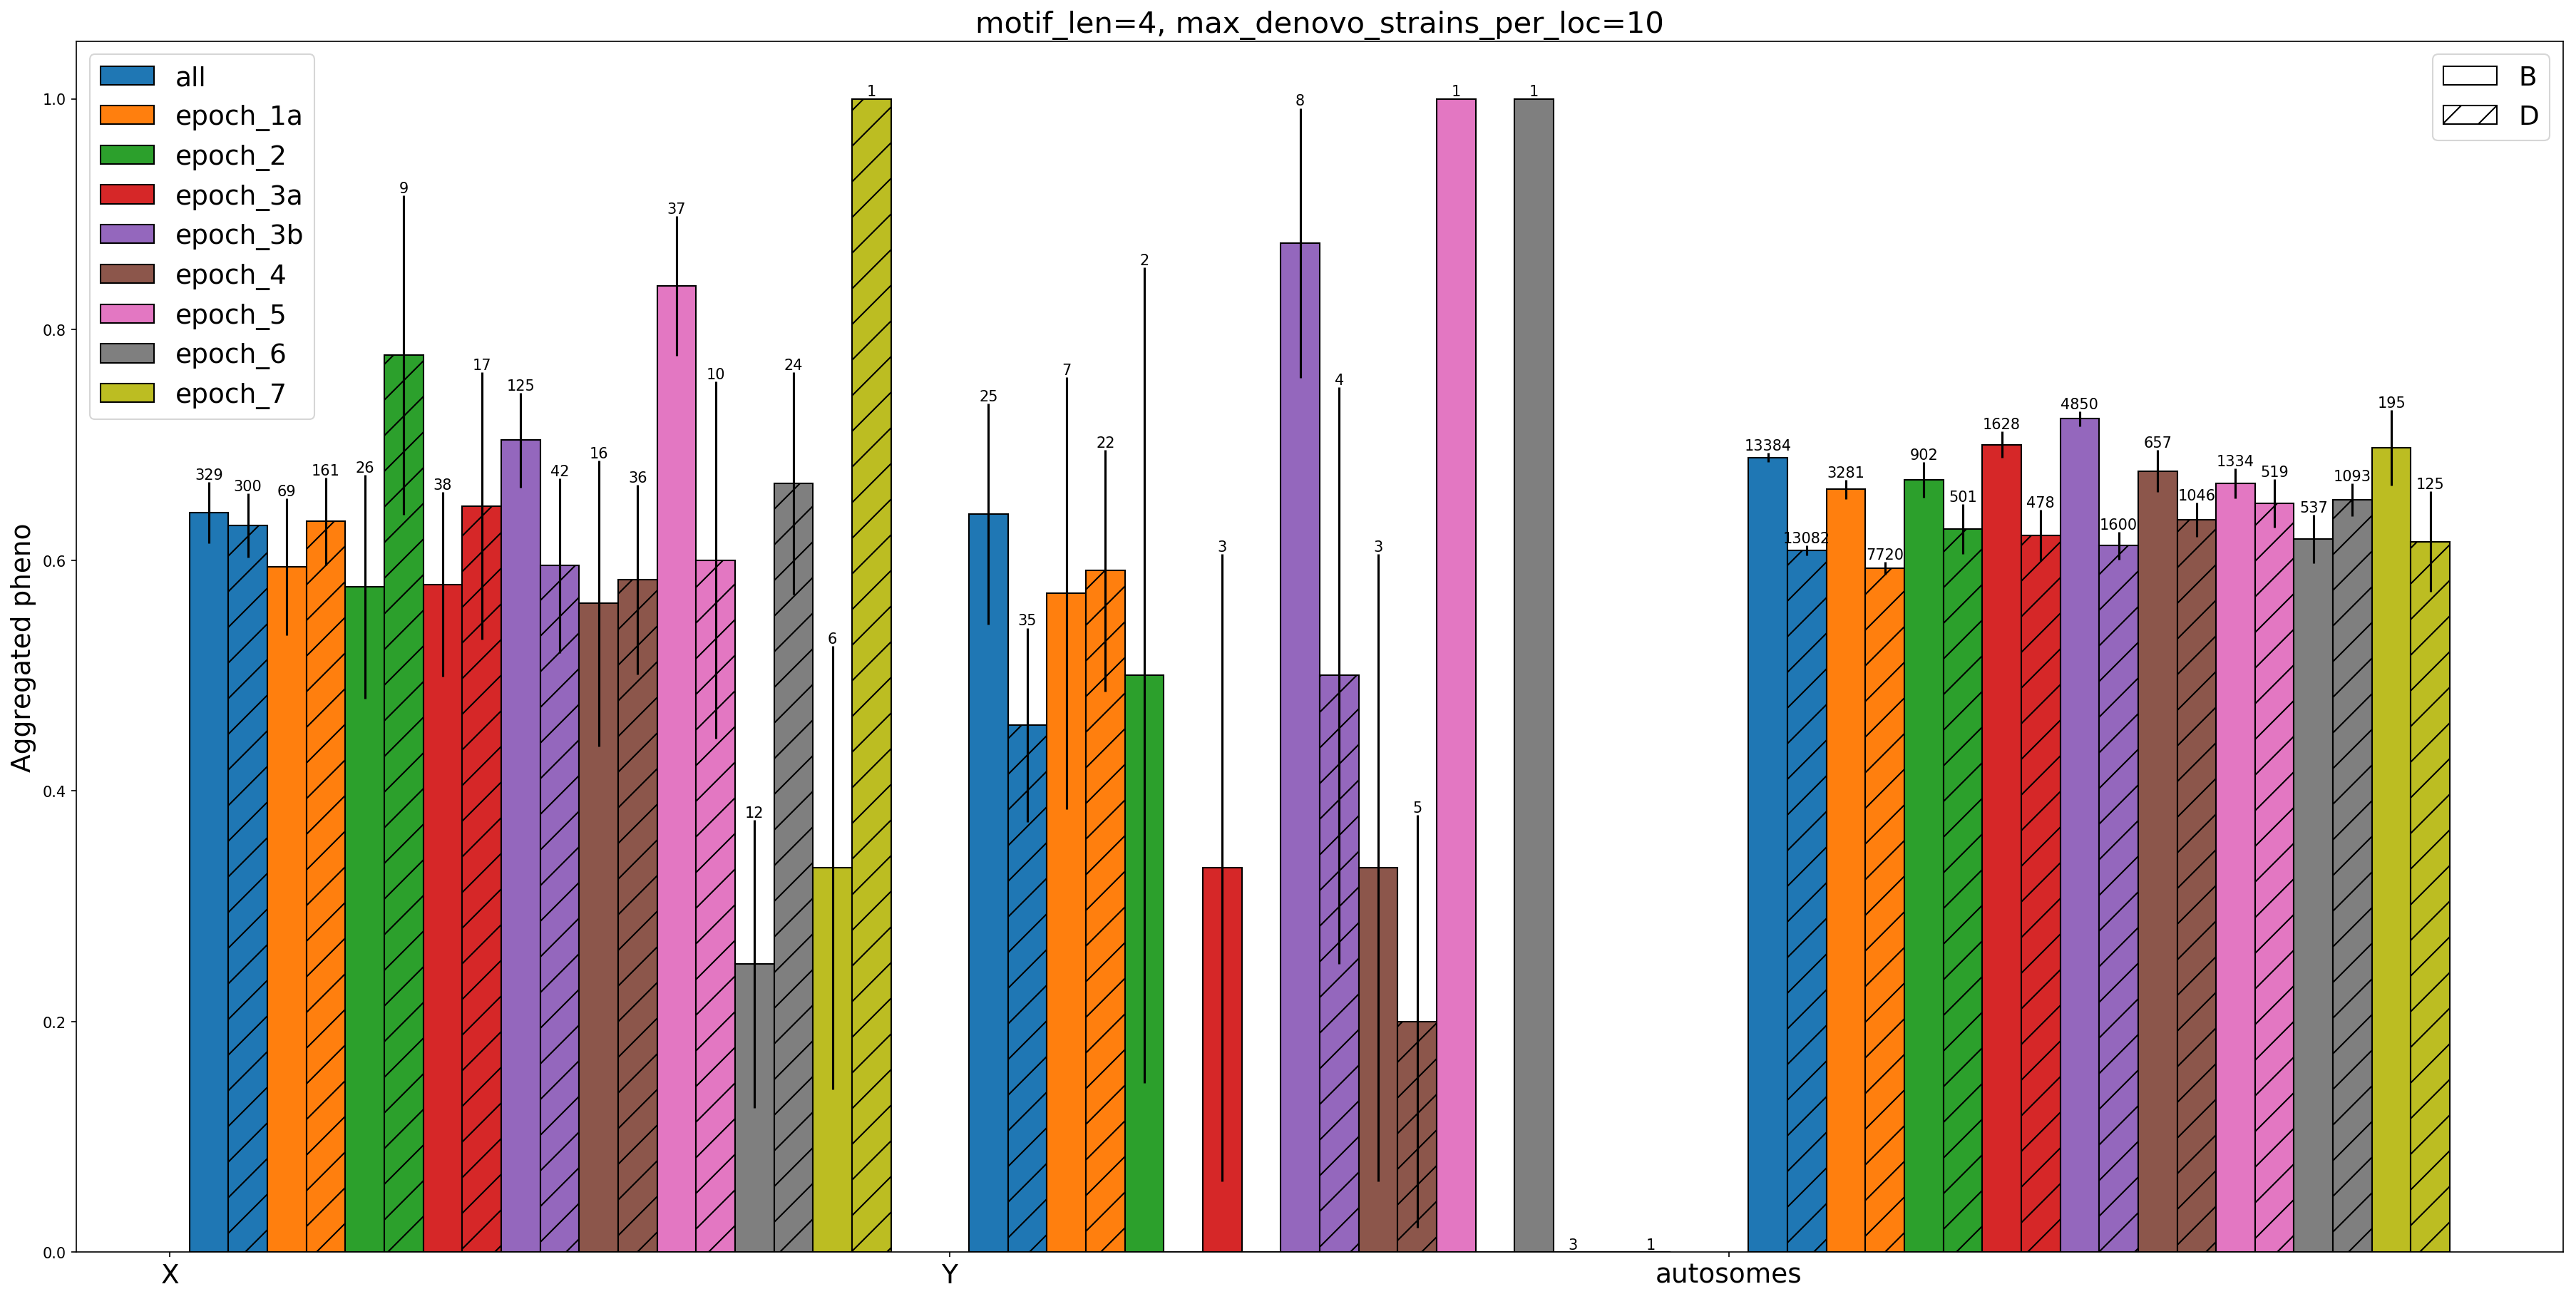

In [617]:
fig, ax = plt.subplots(figsize=(30, 15), dpi=150)
                       
max_denovo_strains_per_loc = 10
motif_len = '4'
epoch = [None, 'epoch_1a','epoch_2','epoch_3a','epoch_3b','epoch_4','epoch_5','epoch_6','epoch_7']
epoch_pheno = []
error = []
totalmut = []
lab_height = []

groups = ['X', 'Y', 'autosomes']
x_axis = np.arange(3)
count = 1
colors = {'all': 'tab:blue', 'epoch_1a':'tab:orange', 'epoch_2':'tab:green', 'epoch_3a':'tab:red', 'epoch_3b':'tab:purple', 'epoch_4':'tab:brown', 'epoch_5':'tab:pink', 'epoch_6':'tab:gray', 'epoch_7':'tab:olive'}

for e in epoch:
    pheno, se, n = get_aggregate_pheno(all_phenos_X_filter, 'B', max_denovo_strains_per_loc, motif_len, e)
    epoch_pheno.append(pheno)
    error.append(se)
    totalmut.append(n)
    lab_height.append(se)
    pheno, se, n = get_aggregate_pheno(all_phenos_Y_filter, 'B', max_denovo_strains_per_loc, motif_len, e)
    epoch_pheno.append(pheno)
    error.append(se)
    totalmut.append(n)
    lab_height.append(se)
    pheno, se, n = get_aggregate_pheno(all_phenos_autosomes_filter, 'B', max_denovo_strains_per_loc, motif_len, e)
    epoch_pheno.append(pheno)
    error.append(se)
    totalmut.append(n)
    lab_height.append(se)
 
    epoch_pheno = [0 if math.isnan(x) else x for x in epoch_pheno]
    if e is None:
        e = 'all'
    plt.bar(x_axis +0.05*count, epoch_pheno, yerr=error, width=0.05, label = e, color=colors[e], edgecolor = 'black')
    epoch_pheno = []
    error = []
    count += 1
    
    if e == 'all':
        e = None
    pheno, se, n = get_aggregate_pheno(all_phenos_X_filter, 'D', max_denovo_strains_per_loc, motif_len, e)
    epoch_pheno.append(pheno)
    error.append(se)
    totalmut.append(n)
    lab_height.append(se)
    pheno, se, n = get_aggregate_pheno(all_phenos_Y_filter, 'D', max_denovo_strains_per_loc, motif_len, e)
    epoch_pheno.append(pheno)
    error.append(se)
    totalmut.append(n)
    lab_height.append(se)
    pheno, se, n = get_aggregate_pheno(all_phenos_autosomes_filter, 'D', max_denovo_strains_per_loc, motif_len, e)
    epoch_pheno.append(pheno)
    error.append(se) 
    totalmut.append(n)
    lab_height.append(se)

    epoch_pheno = [0 if math.isnan(x) else x for x in epoch_pheno]
    if e is None:
        e = 'all'
    plt.bar(x_axis +0.05*count, epoch_pheno, yerr=error, width=0.05, color=colors[e], edgecolor = 'black', hatch='/')
    epoch_pheno = []
    error = []
    
    count += 1

rects = ax.patches
labels = [f"label{i}" for i in range(len(rects))]

for rect, mut, l_height in zip(rects, totalmut, lab_height):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height+ l_height, mut, ha="center", va="bottom")

legend_elements = [Patch(facecolor='white', edgecolor='black', label='B'),
                  Patch(facecolor='white', edgecolor='black', hatch = '/', label='D')]
BD_leg = ax.legend(handles=legend_elements, fontsize=18, loc='upper right')
    
plt.legend(fontsize=18, loc='upper left')
ax.add_artist(BD_leg)


plt.xticks(x_axis,groups, fontsize=18)
plt.ylabel('Aggregated pheno', fontsize=18)
plt.title('motif_len=4, max_denovo_strains_per_loc=10', fontsize=20)
plt.show()
    

/storage/cynthiawu/miniconda3/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in long_scalars
  
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


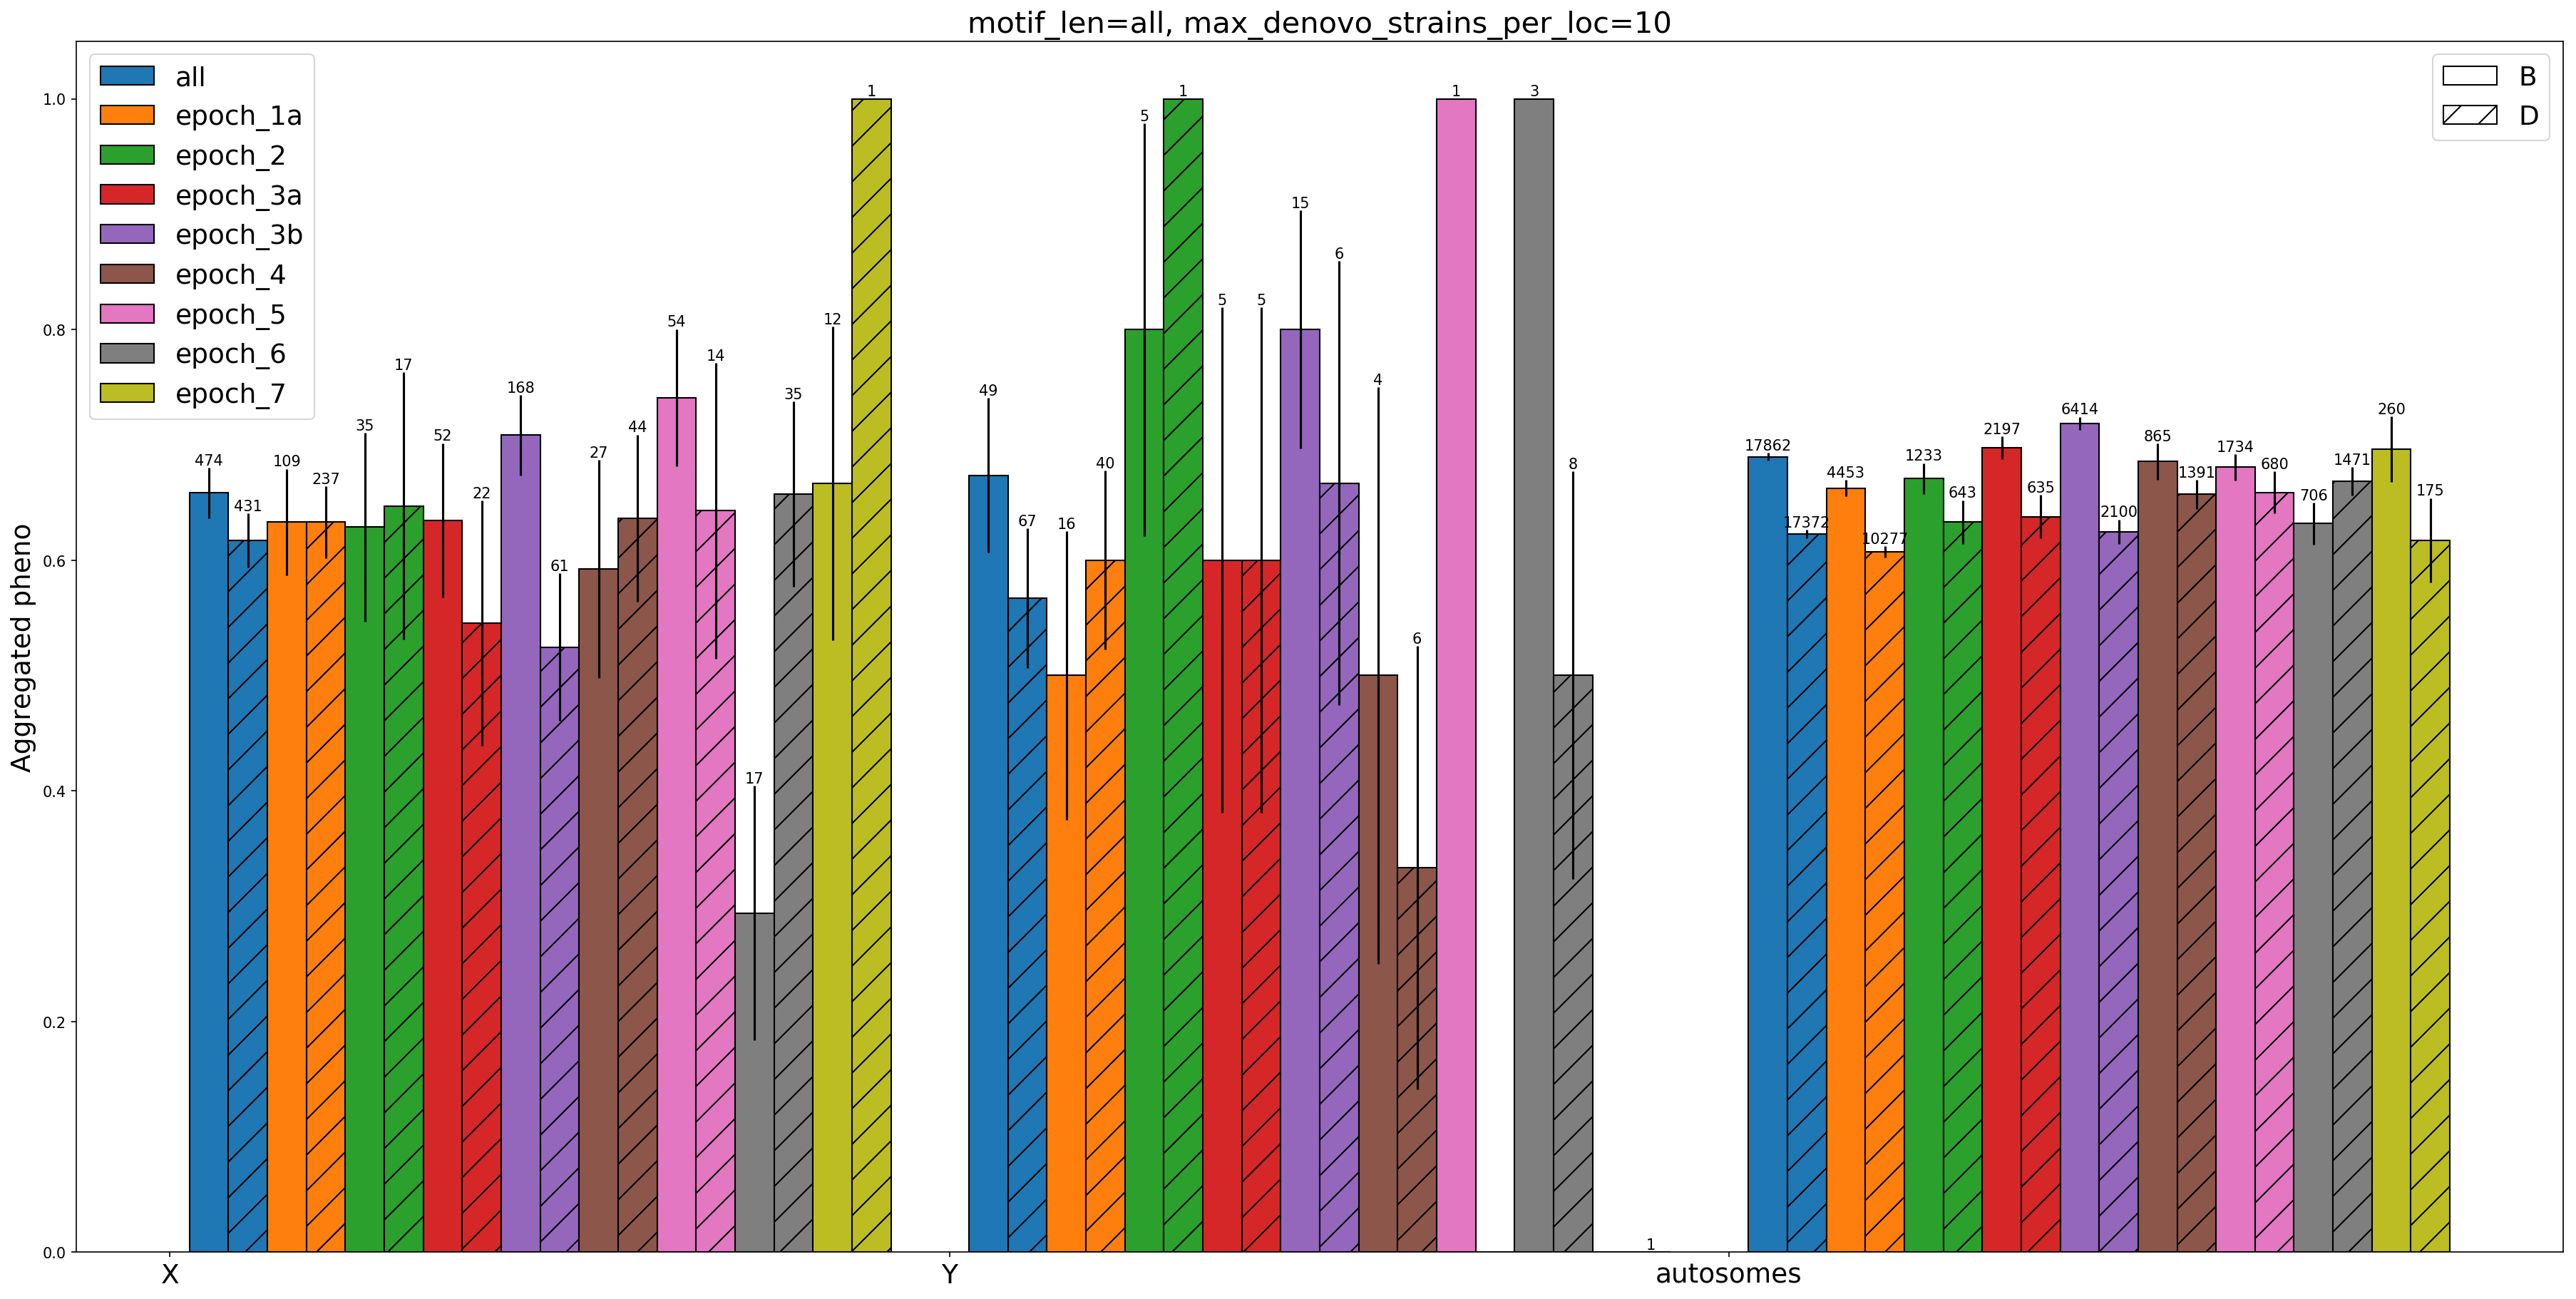

In [521]:
fig, ax = plt.subplots(figsize=(30, 15), dpi=150)
                       
max_denovo_strains_per_loc = 10
motif_len = 'all'
epoch = [None, 'epoch_1a','epoch_2','epoch_3a','epoch_3b','epoch_4','epoch_5','epoch_6','epoch_7']
epoch_pheno = []
error = []
totalmut = []
lab_height = []

groups = ['X', 'Y', 'autosomes']
x_axis = np.arange(3)
count = 1
colors = {'all': 'tab:blue', 'epoch_1a':'tab:orange', 'epoch_2':'tab:green', 'epoch_3a':'tab:red', 'epoch_3b':'tab:purple', 'epoch_4':'tab:brown', 'epoch_5':'tab:pink', 'epoch_6':'tab:gray', 'epoch_7':'tab:olive'}

for e in epoch:
    pheno, se, n = get_aggregate_pheno(all_phenos_X_filter, 'B', max_denovo_strains_per_loc, motif_len, e)
    epoch_pheno.append(pheno)
    error.append(se)
    totalmut.append(n)
    lab_height.append(se)
    pheno, se, n = get_aggregate_pheno(all_phenos_Y_filter, 'B', max_denovo_strains_per_loc, motif_len, e)
    epoch_pheno.append(pheno)
    error.append(se)
    totalmut.append(n)
    lab_height.append(se)
    pheno, se, n = get_aggregate_pheno(all_phenos_autosomes_filter, 'B', max_denovo_strains_per_loc, motif_len, e)
    epoch_pheno.append(pheno)
    error.append(se)
    totalmut.append(n)
    lab_height.append(se)
 
    epoch_pheno = [0 if math.isnan(x) else x for x in epoch_pheno]
    if e is None:
        e = 'all'
    plt.bar(x_axis +0.05*count, epoch_pheno, yerr=error, width=0.05, label = e, color=colors[e], edgecolor = 'black')
    epoch_pheno = []
    error = []
    count += 1
    
    if e == 'all':
        e = None
    pheno, se, n = get_aggregate_pheno(all_phenos_X_filter, 'D', max_denovo_strains_per_loc, motif_len, e)
    epoch_pheno.append(pheno)
    error.append(se)
    totalmut.append(n)
    lab_height.append(se)
    pheno, se, n = get_aggregate_pheno(all_phenos_Y_filter, 'D', max_denovo_strains_per_loc, motif_len, e)
    epoch_pheno.append(pheno)
    error.append(se)
    totalmut.append(n)
    lab_height.append(se)
    pheno, se, n = get_aggregate_pheno(all_phenos_autosomes_filter, 'D', max_denovo_strains_per_loc, motif_len, e)
    epoch_pheno.append(pheno)
    error.append(se) 
    totalmut.append(n)
    lab_height.append(se)

    epoch_pheno = [0 if math.isnan(x) else x for x in epoch_pheno]
    if e is None:
        e = 'all'
    plt.bar(x_axis +0.05*count, epoch_pheno, yerr=error, width=0.05, color=colors[e], edgecolor = 'black', hatch='/')
    epoch_pheno = []
    error = []
    
    count += 1

rects = ax.patches
labels = [f"label{i}" for i in range(len(rects))]

for rect, mut, l_height in zip(rects, totalmut, lab_height):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height+ l_height, mut, ha="center", va="bottom")

legend_elements = [Patch(facecolor='white', edgecolor='black', label='B'),
                  Patch(facecolor='white', edgecolor='black', hatch = '/', label='D')]
BD_leg = ax.legend(handles=legend_elements, fontsize=18, loc='upper right')
    
plt.legend(fontsize=18, loc='upper left')
ax.add_artist(BD_leg)


plt.xticks(x_axis,groups, fontsize=18)
plt.ylabel('Aggregated pheno', fontsize=18)
plt.title('motif_len=all, max_denovo_strains_per_loc=10', fontsize=20)
plt.show()
    